<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 588 (delta 5), reused 3 (delta 1), pack-reused 569
Receiving objects: 100% (588/588), 57.41 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.29.2
Using datasets v2.12.0
Using accelerate v0.19.0
Using sentencepiece v0.1.99
Using umap v0.5.3


# 텍스트 분류

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_tweet.png?raw=1" id="tesla-tweet"/>

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_hf-libraries.png?raw=1" id="hf-libraries"/>

## 데이터셋

### 허깅 페이스 데이터셋 처음 사용하기

In [2]:
from datasets import list_datasets
# list_datasets => 허깅페이스 데이터셋의 리스트가 나옴
all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 37307개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


각 데이터셋은 고유한 이름이 있습니다. `load_dataset()` 함수로 `emotion` 데이터셋을 로드해보죠.

In [3]:
from datasets import load_dataset

# emotion 데이터셋이 다운로드되지 않으면 SetFit/emotion을 사용함
emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# SetFit/emotion 데이터셋의 경우 수동으로 ClassLabel 객체를 만들어 label에 할당합니다.
from datasets import ClassLabel
emotions['train'].features['label'] = ClassLabel(
    num_classes=6,
    names=['sadness','joy','love','anger','fear','surprise']
)

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)

16000

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
train_ds.column_names

['text', 'label']

In [10]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [11]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


In [12]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


### 데이터셋에서 데이터프레임으로

In [13]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

In [14]:
emotions["train"].features['label'].__class__

datasets.features.features.ClassLabel

In [15]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger

### 클래스 분포 살펴 보기

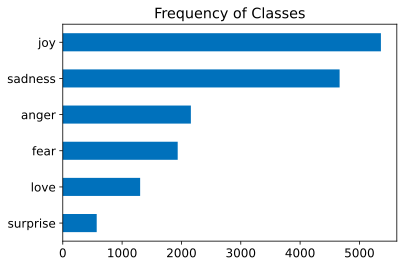

In [ ]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### 트윗 길이 확인

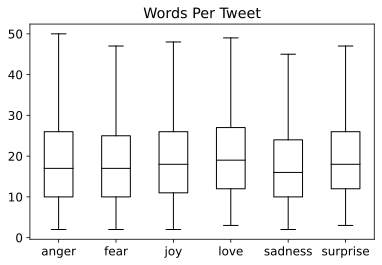

In [ ]:
df['Words Per Tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet",by="label_name",grid=False,
           showfliers=False,color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
emotions.reset_format()

## 텍스트에서 토큰으로

### 문자 토큰

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

Name  Label ID
0      Bumblebee         0
1  Optimus Prime         1
2       Megatron         2

In [ ]:
pd.get_dummies(categorical_df["Name"])

Bumblebee  Megatron  Optimus Prime
0          1         0              0
1          0         0              1
2          0         1              0

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [ ]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
F.one_hot(torch.tensor([0,2]), num_classes=11).shape

torch.Size([2, 11])

In [ ]:
import tensorflow as tf

tf.one_hot([0,1, 2], 1)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.]], dtype=float32)>

### 단어 토큰화

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### 부분단어 토큰화

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 전체 데이터셋 토큰화하기

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


In [ ]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

0      1      2      3       4
Special Token     [PAD]  [UNK]  [CLS]  [SEP]  [MASK]
Special Token ID      0    100    101    102     103

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/> 

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'label_text', 'input_ids', 'attention_mask']


## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### 사이드바: 프레임워크 간의 상호 운영성

In [ ]:
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [ ]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

### 사이드바 끝

#### 마지막 은닉 상태 추출하기

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [ ]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state']

#### 특성 행렬 만들기

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### 훈련 세트 시각화하기

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

X         Y  label
0  4.081637  6.589655      0
1 -2.853412  5.993978      0
2  5.320372  3.292638      3
3 -2.389295  3.515101      2
4 -3.294883  3.873651      3

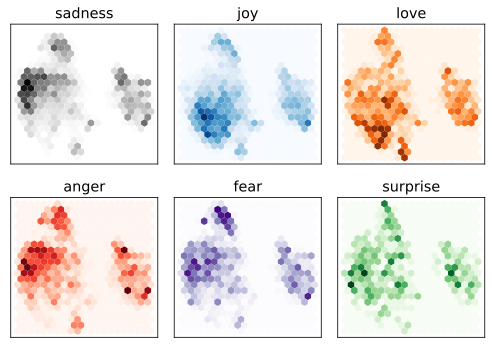

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [ ]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

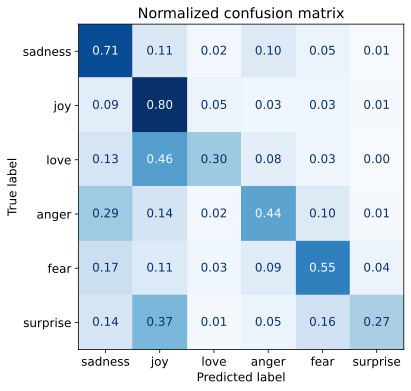

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 트랜스포머 미세 튜닝하기

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

#### 성공 지표 정의하기

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.39k/255M [00:00<?, ?B/s]

Download file runs/Sep04_00-42-37_d7cb327b0589/1662252292.2464943/events.out.tfevents.1662252292.d7cb327b0589.…

Download file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

Download file runs/Jul31_14-36-39_7c2acc53f4d0/events.out.tfevents.1659278477.7c2acc53f4d0.73.0: 100%|########…

Download file runs/Jan02_05-30-47_e4e4e3d27cc5/events.out.tfevents.1672637653.e4e4e3d27cc5.185.0: 100%|#######…

Download file runs/Jul31_14-36-39_7c2acc53f4d0/1659278477.776739/events.out.tfevents.1659278477.7c2acc53f4d0.7…

Clean file runs/Sep04_00-42-37_d7cb327b0589/1662252292.2464943/events.out.tfevents.1662252292.d7cb327b0589.110…

Download file runs/Sep04_00-42-37_d7cb327b0589/events.out.tfevents.1662252292.d7cb327b0589.1102.0: 100%|######…

Clean file training_args.bin:  30%|##9       | 1.00k/3.37k [00:00<?, ?B/s]

Download file runs/Jan02_05-30-47_e4e4e3d27cc5/1672637653.9897866/events.out.tfevents.1672637653.e4e4e3d27cc5.…

Clean file runs/Jul31_14-36-39_7c2acc53f4d0/events.out.tfevents.1659278477.7c2acc53f4d0.73.0:  21%|##        |…

Clean file runs/Jan02_05-30-47_e4e4e3d27cc5/events.out.tfevents.1672637653.e4e4e3d27cc5.185.0:  19%|#9        …

Clean file runs/Jul31_14-36-39_7c2acc53f4d0/1659278477.776739/events.out.tfevents.1659278477.7c2acc53f4d0.73.1…

Clean file runs/Sep04_00-42-37_d7cb327b0589/events.out.tfevents.1662252292.d7cb327b0589.1102.0:  19%|#9       …

Clean file runs/Jan02_05-30-47_e4e4e3d27cc5/1672637653.9897866/events.out.tfevents.1672637653.e4e4e3d27cc5.185…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.21552352607250214,
 'test_accuracy': 0.9255,
 'test_f1': 0.9256314817870995,
 'test_runtime': 3.993,
 'test_samples_per_second': 500.878,
 'test_steps_per_second': 8.014}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

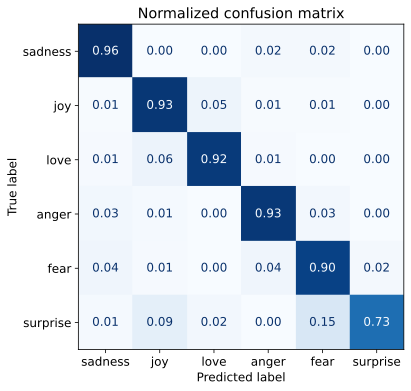

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

### 사이드바: 케라스로 미세 튜닝하기

In [ ]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
# 텐서플로 텐서로 변환할 열 이름
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [ ]:
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


250/250 [==============================] - 178s 544ms/step - loss: 0.5350 - sparse_categorical_accuracy: 0.8094 - val_loss: 0.1717 - val_sparse_categorical_accuracy: 0.9385
Epoch 2/2
250/250 [==============================] - 134s 538ms/step - loss: 0.1524 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.1383 - val_sparse_categorical_accuracy: 0.9370


### 사이드바 끝

#### 오류 분석

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

text     label  \
1950  i as representative of everything thats wrong ...  surprise   
1963  i called myself pro life and voted for perry w...       joy   
1801  i feel that he was being overshadowed by the s...      love   
1274  i am going to several holiday parties and i ca...       joy   
765     i feel super awkward and out of place right now       joy   
1870  i guess i feel betrayed because i admired him ...       joy   
465   i would eventually go in to these stores but i...       joy   
882   i feel badly about reneging on my commitment t...      love   
1509  i guess this is a memoir so it feels like that...       joy   
1111  im lazy my characters fall into categories of ...       joy   

     predicted_label      loss  
1950         sadness  5.623446  
1963         sadness  5.619520  
1801         sadness  5.607580  
1274         sadness  5.604027  
765          sadness  5.509608  
1870         sadness  5.346349  
465             fear  5.260897  
882          sadness  4.995311  
1509            fear  4.617338  
1111            fear  4.522757

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

text label predicted_label  \
1873  i feel practically virtuous this month i have ...   joy             joy   
19    i had lunch with an old friend and it was nice...   joy             joy   
1012  i definitely succumbed to pre holiday sales bu...   joy             joy   
1226  im feeling terrific and in great shape im opti...   joy             joy   
632           i feel he is an terrific really worth bet   joy             joy   
329   i have had my treasury selection on the front ...   joy             joy   
1688  i feel very very rich and fulfilled and a part...   joy             joy   
1513  i have also been getting back into my gym rout...   joy             joy   
222               i am at day and i am feeling terrific   joy             joy   
1901  i believe my ground game is where i feel most ...   joy             joy   

          loss  
1873  0.015129  
19    0.015413  
1012  0.015463  
1226  0.015629  
632   0.015699  
329   0.015712  
1688  0.015743  
1513  0.015774  
222   0.015783  
1901  0.015839

#### 모델 저장 및 공유

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion
   b9712fd..0a72b17  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion
   b9712fd..0a72b17  main -> main

To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion
   0a72b17..03811cd  main -> main

   0a72b17..03811cd  main -> main



'https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion/commit/0a72b17536e9934a6dae5f5335d31184534b1d49'

In [ ]:
from transformers import pipeline

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_id = "haesun/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


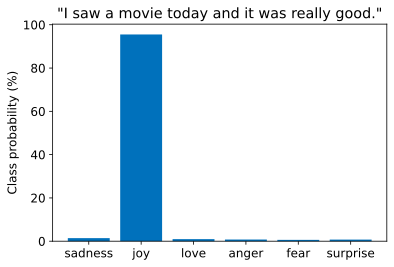

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## 결론